# Urban Issues Classifier Analysis
Analysis of the training results and model performance.

In [1]:
import json
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import sys

sys.path.append('..')
from src.models.classifier import UrbanIssuesClassifier
from src.data.dataset import UrbanIssuesDataset

## Learning Curves

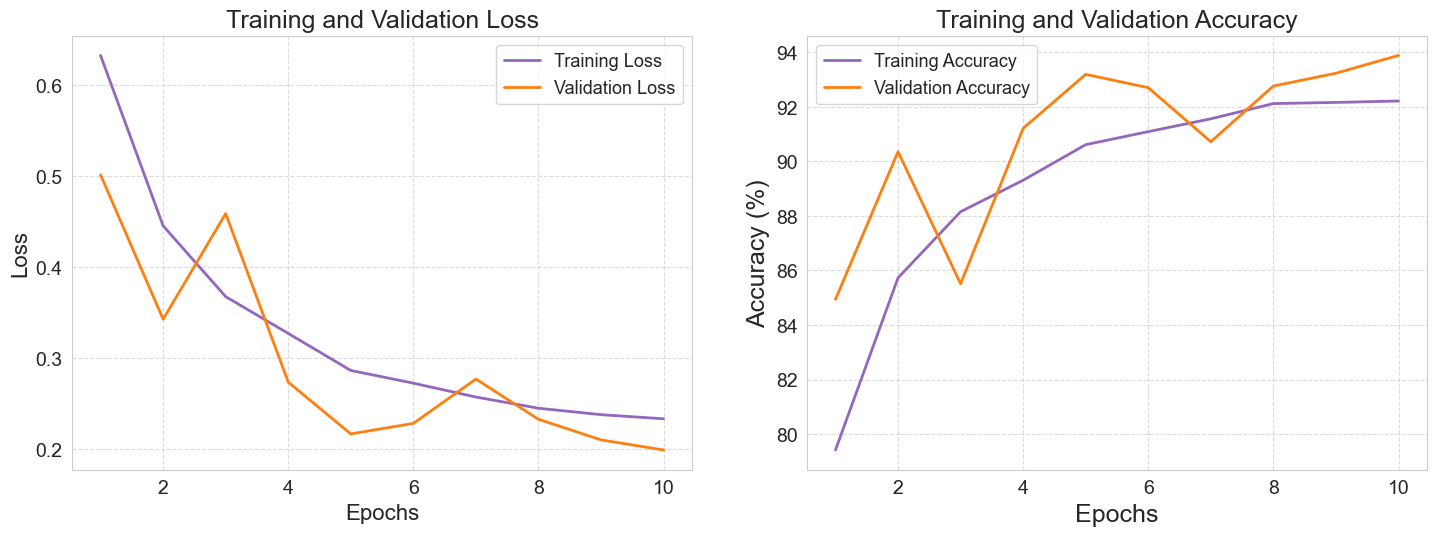

In [2]:
import seaborn as sns
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

with open('../history.json', 'r') as f:
    history = json.load(f)

epochs = range(1, len(history['train_loss']) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2)

# Loss Plot
ax1.plot(epochs, history['train_loss'], 'tab:purple', label='Training Loss', linewidth=2)
if 'valid_loss' in history and history['valid_loss']:
    ax1.plot(epochs, history['valid_loss'], 'tab:orange', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=18)
ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax1.legend(fontsize=13)
ax1.grid(True, linestyle='--', alpha=0.7)
# Increase grid/tick font size
ax1.tick_params(labelsize=14)

# Accuracy Plot
ax2.plot(epochs, history['train_acc'], 'tab:purple', label='Training Accuracy', linewidth=2)
ax2.plot(epochs, history['valid_acc'], 'tab:orange', label='Validation Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy', fontsize=18)
ax2.set_xlabel('Epochs', fontsize=18)
ax2.set_ylabel('Accuracy (%)', fontsize=18)
ax2.legend(fontsize=13)
ax2.grid(True, linestyle='--', alpha=0.7)
# Increase grid/tick font size
ax2.tick_params(labelsize=14)

# Increase spacing between subplots
plt.tight_layout(pad=3.0, w_pad=4.0)
plt.show()

## Model Inference

In [3]:
# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 9
model = UrbanIssuesClassifier(num_classes=num_classes, pretrained=False)
model.load_state_dict(torch.load('../best_model.pth', map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Get class names
dataset = UrbanIssuesDataset(root_dir='../data', split='test', transform=transform)
classes = dataset.classes
print(f"Classes: {classes}")

Classes: ['Damaged concrete structures', 'DamagedElectricalPoles', 'DamagedRoadSigns', 'DeadAnimalsPollution', 'FallenTrees', 'Garbage', 'Graffitti', 'IllegalParking', 'Potholes and RoadCracks']


## Confusion Matrix

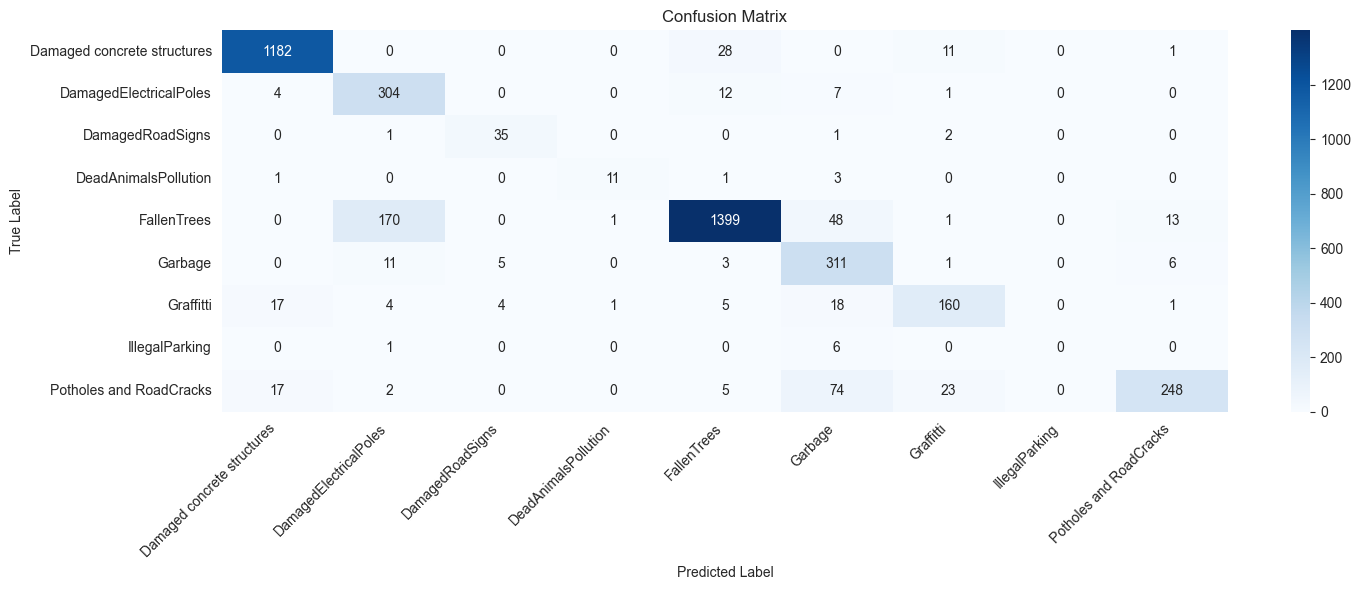

In [4]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions
y_true = []
y_pred = []

valid_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(15, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
dataset